# Prediction of Hourly Energy Consumption of Turkey

Predicting the power demand with high accuracy might introduce a great set of values for a country, for a city or even for households. Stakeholders might adjust their power production accordingly to reduce cost; or they can buy sufficient amounts of energy if they meet their power needs from external sources. In some certain cases, such as in tendering processes in a daily energy exchange, the stakeholders may generate addtional profit, too. 

In this notebook I will introduce basics of training a Machine Learning model predicting Power Consumption of Turkey for the next 24 hours, using Ensemble Methods.

## Importing and Processing the Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../input/hourly-power-consumption-of-turkey-20162020/RealTimeConsumption-01012016-04082020.csv', encoding='cp1254')

In [3]:
df.head()

,Date,Hour,Consumption (MWh)
0,01.01.2016,00:00,"26,277.24"
1,01.01.2016,01:00,"24,991.82"
2,01.01.2016,02:00,"23,532.61"
3,01.01.2016,03:00,"22,464.78"
4,01.01.2016,04:00,"22,002.91"


In [4]:
df['Date'] =pd.to_datetime(df['Date'] +' '+ df['Hour'], format='%d.%m.%Y %H:%M')

Let's check whether we miss any entry in the time series "Data" feature:

In [5]:
pd.date_range(start = '2016-01-01 00:00:00', end = '2020-03-24 00:00:00', freq = 'D').difference(df.Date)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [6]:
df = df.drop('Hour', axis = 1)

In [7]:
df.head()

,Date,Consumption (MWh)
0,2016-01-01 00:00:00,"26,277.24"
1,2016-01-01 01:00:00,"24,991.82"
2,2016-01-01 02:00:00,"23,532.61"
3,2016-01-01 03:00:00,"22,464.78"
4,2016-01-01 04:00:00,"22,002.91"


In [8]:
df['Consumption (MWh)'] = df['Consumption (MWh)'].str.replace(',','')
df['Consumption (MWh)'] = pd.to_numeric(df['Consumption (MWh)'])

In [9]:
df = df.sort_values('Date')

In [10]:
df.head()

,Date,Consumption (MWh)
0,2016-01-01 00:00:00,26277.24
1,2016-01-01 01:00:00,24991.82
2,2016-01-01 02:00:00,23532.61
3,2016-01-01 03:00:00,22464.78
4,2016-01-01 04:00:00,22002.91


In [11]:
print(df['Date'].min(), df['Date'].max())

2016-01-01 00:00:00 2020-08-04 23:00:00


For the purposes of this notebook, I will not be including the Covid period as approximately started in Turkey:

In [12]:
df = df.set_index('Date').loc[:'2020-03-24 23:00:00', :].reset_index()

In [13]:
df.tail()

,Date,Consumption (MWh)
37075,2020-03-24 19:00:00,35584.14
37076,2020-03-24 20:00:00,35189.92
37077,2020-03-24 21:00:00,34187.54
37078,2020-03-24 22:00:00,33505.39
37079,2020-03-24 23:00:00,32021.62


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37080 entries, 0 to 37079
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               37080 non-null  datetime64[ns]
 1   Consumption (MWh)  37080 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 579.5 KB


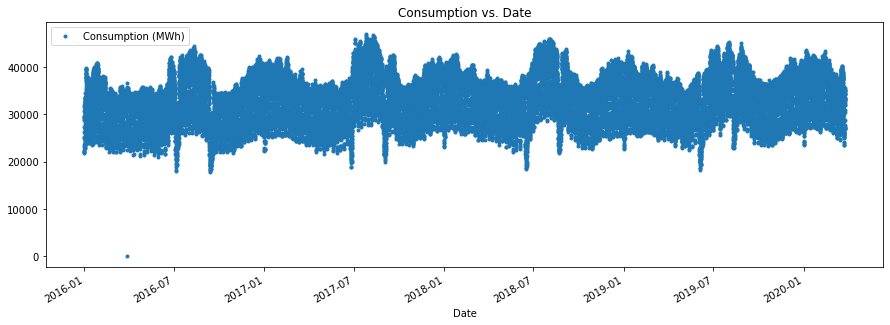

In [15]:
df.set_index('Date').plot(style='.', figsize=(15,5), title='Consumption vs. Date')
plt.show()

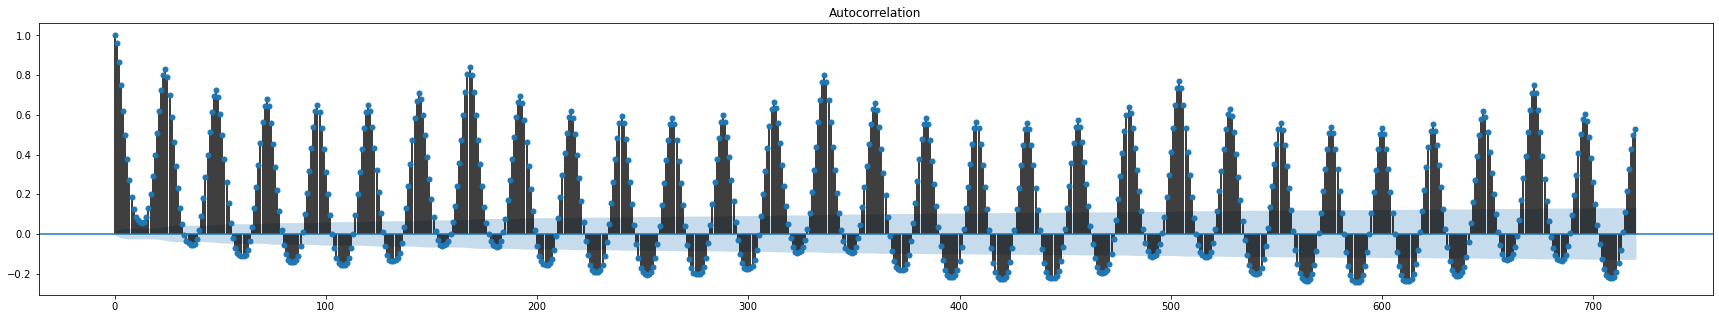

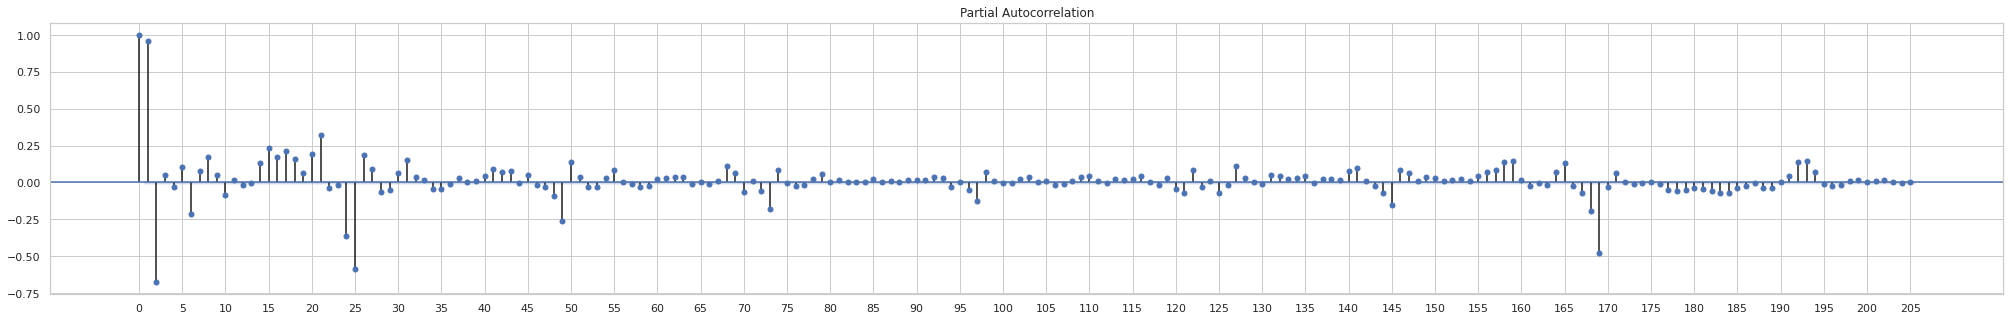

In [16]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(30, 5))
plot_acf(df.set_index('Date'),lags = 720, ax=ax)
plt.show()


sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(35, 5))
plot_pacf(df.set_index('Date'),lags = 205, ax=ax)
plt.xticks(np.arange(0, 210, step=5))
plt.show()

Text(0.5, 1.0, 'Hourly Consumption')

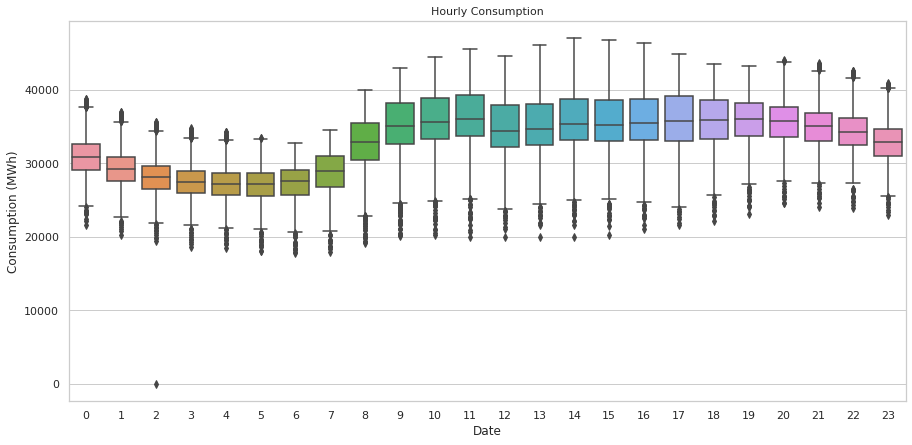

In [17]:
plt.figure(figsize = (15, 7))
ax = sns.boxplot(x=df['Date'].dt.hour, y="Consumption (MWh)", data=df)
plt.title('Hourly Consumption', fontsize=11)

In [18]:
df['Consumption (MWh)'] = np.log1p(df['Consumption (MWh)'])

## Basic Feature Engineering

### Lag Features

In [19]:
df['rolling_mean_t41'] = df['Consumption (MWh)'].shift(38)
df['rolling_mean_t41'] = df['Consumption (MWh)'].shift(41)
df['rolling_mean_t48'] = df['Consumption (MWh)'].shift(48)
df['rolling_mean_t72'] = df['Consumption (MWh)'].shift(72) 
df['rolling_mean_t168'] = df['Consumption (MWh)'].shift(168)

In [20]:
df

,Date,Consumption (MWh),rolling_mean_t41,rolling_mean_t48,rolling_mean_t72,rolling_mean_t168
0,2016-01-01 00:00:00,10.176496,NaN,NaN,NaN,NaN
1,2016-01-01 01:00:00,10.126344,NaN,NaN,NaN,NaN
2,2016-01-01 02:00:00,10.066185,NaN,NaN,NaN,NaN
3,2016-01-01 03:00:00,10.019749,NaN,NaN,NaN,NaN
4,2016-01-01 04:00:00,9.998975,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
37075,2020-03-24 19:00:00,10.479683,10.158169,10.396895,10.490146,10.572474
37076,2020-03-24 20:00:00,10.468543,10.134094,10.403032,10.494903,10.565442
37077,2020-03-24 21:00:00,10.439646,10.129021,10.368976,10.464276,10.537836
37078,2020-03-24 22:00:00,10.419491,10.141702,10.345436,10.426128,10.501170


### Rolling Features

In [21]:
df['rolling_mean_t38'] = df['Consumption (MWh)'].transform(lambda x: x.shift(38).rolling(12).mean())
df['rolling_mean_t50'] = df['Consumption (MWh)'].transform(lambda x: x.shift(38).rolling(24).mean())
df['rolling_mean_t62'] = df['Consumption (MWh)'].transform(lambda x: x.shift(38).rolling(48).mean())
df['rolling_median_t38'] = df['Consumption (MWh)'].transform(lambda x: x.shift(38).rolling(12).median())
df['rolling_median_t50'] = df['Consumption (MWh)'].transform(lambda x: x.shift(38).rolling(24).median())
df['rolling_median_t62'] = df['Consumption (MWh)'].transform(lambda x: x.shift(38).rolling(48).median())
df['rolling_std_t38'] = df['Consumption (MWh)'].transform(lambda x: x.shift(38).rolling(12).std())
df['rolling_std_t50'] = df['Consumption (MWh)'].transform(lambda x: x.shift(38).rolling(24).std())
df['rolling_std_t62'] = df['Consumption (MWh)'].transform(lambda x: x.shift(38).rolling(48).std())

In [22]:
df

,Date,Consumption (MWh),rolling_mean_t41,rolling_mean_t48,rolling_mean_t72,rolling_mean_t168,rolling_mean_t38,rolling_mean_t50,rolling_mean_t62,rolling_median_t38,rolling_median_t50,rolling_median_t62,rolling_std_t38,rolling_std_t50,rolling_std_t62
0,2016-01-01 00:00:00,10.176496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 01:00:00,10.126344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01 02:00:00,10.066185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01 03:00:00,10.019749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01 04:00:00,9.998975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37075,2020-03-24 19:00:00,10.479683,10.158169,10.396895,10.490146,10.572474,10.264401,10.201560,10.268439,10.283881,10.156630,10.263716,0.107235,0.106024,0.120718
37076,2020-03-24 20:00:00,10.468543,10.134094,10.403032,10.494903,10.565442,10.249979,10.201589,10.266187,10.228301,10.156966,10.261821,0.109399,0.106011,0.121809
37077,2020-03-24 21:00:00,10.439646,10.129021,10.368976,10.464276,10.537836,10.231135,10.205125,10.264767,10.184831,10.164465,10.261821,0.100941,0.103366,0.122528
37078,2020-03-24 22:00:00,10.419491,10.141702,10.345436,10.426128,10.501170,10.224275,10.215967,10.265105,10.184831,10.171519,10.261821,0.090449,0.101161,0.122662


In [23]:
df = df.dropna(axis=0, how='any').reset_index(drop=True)

### Time Features

In [24]:
df['hourofday'] = df['Date'].dt.hour
df['quarter'] = df['Date'].dt.quarter
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['dayofyear'] = df['Date'].dt.dayofyear
df['dayofmonth'] = df['Date'].dt.day
df['weekofyear'] = df['Date'].dt.weekofyear
df['days_in_month'] = df['Date'].dt.days_in_month

In [25]:
df.head()

,Date,Consumption (MWh),rolling_mean_t41,rolling_mean_t48,rolling_mean_t72,rolling_mean_t168,rolling_mean_t38,rolling_mean_t50,rolling_mean_t62,rolling_median_t38,...,rolling_std_t50,rolling_std_t62,hourofday,quarter,month,year,dayofyear,dayofmonth,weekofyear,days_in_month
0,2016-01-08 00:00:00,10.261268,10.258853,10.281591,10.283477,10.176496,10.286262,10.397811,10.405176,10.242484,...,0.151209,0.155102,0,1,1,2016,8,8,1,31
1,2016-01-08 01:00:00,10.207782,10.410436,10.226115,10.226955,10.126344,10.301210,10.396919,10.404201,10.242484,...,0.150254,0.154070,1,1,1,2016,8,8,1,31
2,2016-01-08 02:00:00,10.164941,10.498421,10.187913,10.178722,10.066185,10.319135,10.395417,10.402959,10.242484,...,0.149013,0.153056,2,1,1,2016,8,8,1,31
3,2016-01-08 03:00:00,10.139214,10.524438,10.155032,10.160887,10.019749,10.342480,10.393985,10.401455,10.334645,...,0.147716,0.151642,3,1,1,2016,8,8,1,31
4,2016-01-08 04:00:00,10.131784,10.541274,10.160670,10.164931,9.998975,10.369701,10.392607,10.399921,10.453558,...,0.146369,0.150078,4,1,1,2016,8,8,1,31


In [26]:
df.tail()

,Date,Consumption (MWh),rolling_mean_t41,rolling_mean_t48,rolling_mean_t72,rolling_mean_t168,rolling_mean_t38,rolling_mean_t50,rolling_mean_t62,rolling_median_t38,...,rolling_std_t50,rolling_std_t62,hourofday,quarter,month,year,dayofyear,dayofmonth,weekofyear,days_in_month
36907,2020-03-24 19:00:00,10.479683,10.158169,10.396895,10.490146,10.572474,10.264401,10.201560,10.268439,10.283881,...,0.106024,0.120718,19,1,3,2020,84,24,13,31
36908,2020-03-24 20:00:00,10.468543,10.134094,10.403032,10.494903,10.565442,10.249979,10.201589,10.266187,10.228301,...,0.106011,0.121809,20,1,3,2020,84,24,13,31
36909,2020-03-24 21:00:00,10.439646,10.129021,10.368976,10.464276,10.537836,10.231135,10.205125,10.264767,10.184831,...,0.103366,0.122528,21,1,3,2020,84,24,13,31
36910,2020-03-24 22:00:00,10.419491,10.141702,10.345436,10.426128,10.501170,10.224275,10.215967,10.265105,10.184831,...,0.101161,0.122662,22,1,3,2020,84,24,13,31
36911,2020-03-24 23:00:00,10.374198,10.155763,10.310060,10.388948,10.451028,10.225796,10.229460,10.265967,10.184831,...,0.101521,0.123385,23,1,3,2020,84,24,13,31


### Train-Test Split

In [27]:
split_date = '01-Jan-2016'
split_date1 = '01-Jan-2020'
split_date2 = '14-Mar-2020'
split_date3 = '15-Mar-2020'
df_train = df.set_index('Date').loc[split_date:'31-Dec-2019', :].reset_index()
df_test = df.set_index('Date').loc[split_date1:split_date2, :].reset_index()

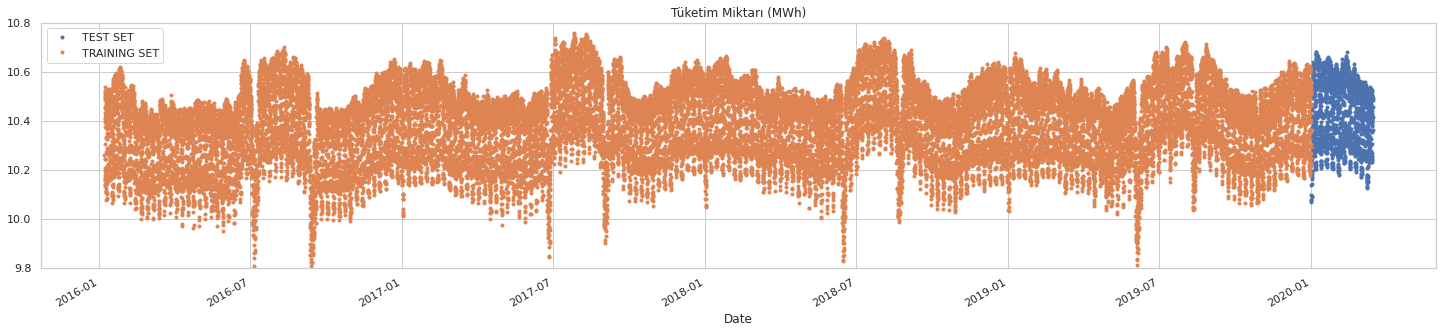

In [28]:
df_test[['Date','Consumption (MWh)']].set_index('Date').rename(columns={'Consumption (MWh)': 'TEST SET'})\
        .join(df_train[['Date','Consumption (MWh)']].set_index('Date')\
              .rename(columns={'Consumption (MWh)': 'TRAINING SET'}),how='outer').plot(figsize=(25,5), title='Tüketim Miktarı (MWh)', style='.')
plt.ylim(9.8, 10.8)
plt.show()

In [29]:
df_train.to_csv('energy_cons_train.csv', index = None) #Keeping the train and test data for another notebook :)
df_test.to_csv('energy_cons_test.csv', index = None)

In [30]:
df_train = df_train.drop(['Date'], axis=1)
df_test = df_test.drop(['Date'], axis=1)

## The Model

In [31]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [32]:
print(df_train.shape, df_test.shape) 

(34896, 22) (1776, 22)


In [33]:
y_train = df_train['Consumption (MWh)'].values
X_train = df_train.drop('Consumption (MWh)', axis=1).values

y_test = df_test['Consumption (MWh)'].values
X_test = df_test.drop('Consumption (MWh)', axis=1).values

In [34]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#!pip install lightgbm
from lightgbm import LGBMRegressor

In [35]:
model_lgbm = LGBMRegressor(objective='rmse', n_estimators=3000, learning_rate=0.01, num_leaves=36, min_child_samples = 15, 
                           n_jobs=-1,  random_state = None, max_depth = 3, reg_lambda = 0.0, reg_alpha = 0.0, min_split_gain=0.0)
eval_set_ALLRESTS = [(X_train, y_train), (X_test, y_test)]
model_lgbm.fit(X_train, y_train, eval_set = eval_set_ALLRESTS ,eval_metric='rmse', early_stopping_rounds=15, verbose=20)

Training until validation scores don't improve for 15 rounds
[20]	training's rmse: 0.14446	valid_1's rmse: 0.123812
[40]	training's rmse: 0.130438	valid_1's rmse: 0.107061
[60]	training's rmse: 0.119715	valid_1's rmse: 0.0942807
[80]	training's rmse: 0.111582	valid_1's rmse: 0.0844054
[100]	training's rmse: 0.105413	valid_1's rmse: 0.0770641
[120]	training's rmse: 0.100738	valid_1's rmse: 0.071497
[140]	training's rmse: 0.0971423	valid_1's rmse: 0.0674427
[160]	training's rmse: 0.0944462	valid_1's rmse: 0.0647495
[180]	training's rmse: 0.0923904	valid_1's rmse: 0.0627855
[200]	training's rmse: 0.0907881	valid_1's rmse: 0.0612755
[220]	training's rmse: 0.0894657	valid_1's rmse: 0.0601027
[240]	training's rmse: 0.0883913	valid_1's rmse: 0.0591765
[260]	training's rmse: 0.0875542	valid_1's rmse: 0.058626
[280]	training's rmse: 0.0868544	valid_1's rmse: 0.058137
[300]	training's rmse: 0.0862689	valid_1's rmse: 0.057728
[320]	training's rmse: 0.0858019	valid_1's rmse: 0.057459
[340]	trainin

LGBMRegressor(learning_rate=0.01, max_depth=3, min_child_samples=15,
              n_estimators=3000, num_leaves=36, objective='rmse')

In [36]:
y_train_lgbm = model_lgbm.predict(X_train)
print("Train set RMSE (Log): " + str(np.sqrt(mean_squared_error(y_train_lgbm, y_train))))
print("Train set MAPE (Log): " + str(mean_absolute_percentage_error(y_train, y_train_lgbm)))
print("Train set RMSE (Non-Log): " + str(np.sqrt(mean_squared_error(np.expm1(y_train_lgbm), np.expm1(y_train)))))
print("Train set MAPE (Non-Log): " + str(mean_absolute_percentage_error(np.expm1(y_train), np.expm1(y_train_lgbm))))
print("% Success (Non-Log): " + str(100 - mean_absolute_percentage_error(np.expm1(y_train), np.expm1(y_train_lgbm))))

Train set RMSE (Log): 0.08027037006482328
Train set MAPE (Log): 0.36199918497744477
Train set RMSE (Non-Log): 1883.6518541418754
Train set MAPE (Non-Log): 3.77903096898771
% Success (Non-Log): 96.22096903101229


In [37]:
y_test_lgbm = model_lgbm.predict(X_test)
print("Validation set RMSE (Log): " + str(np.sqrt(mean_squared_error(y_test_lgbm, y_test))))
print("Validation set MAPE (Log): " + str(mean_absolute_percentage_error(y_test, y_test_lgbm)))
print("Validation set RMSE (Non-Log): " + str(np.sqrt(mean_squared_error(np.expm1(y_test_lgbm), np.expm1(y_test)))))
print("Validation set MAPE (Non-Log): " + str(mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_test_lgbm))))
print("% Success (Non-Log): " + str(100 - mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_test_lgbm))))

Validation set RMSE (Log): 0.048082906764366815
Validation set MAPE (Log): 0.31060464728053844
Validation set RMSE (Non-Log): 1672.158226302014
Validation set MAPE (Non-Log): 3.259334799927164
% Success (Non-Log): 96.74066520007284


We may say that our model performed ~96.2% on train set and ~96.7% on the test set, not bad isn't it!

<Figure size 1224x576 with 0 Axes>

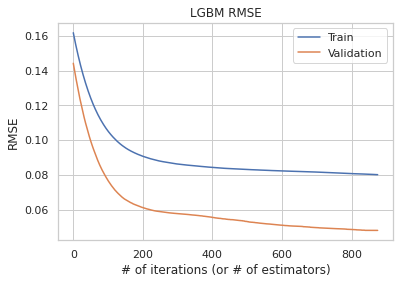

In [38]:
from matplotlib import pyplot
# retrieve performance metrics
results = model_lgbm.evals_result_
epochs = len(results['training']['rmse'])
x_axis = range(0, epochs)
# plot MAE
plt.figure(figsize=(17,8))
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['training']['rmse'], label='Train')
ax.plot(x_axis, results['valid_1']['rmse'], label='Validation')
ax.legend();
pyplot.ylabel('RMSE')
pyplot.xlabel('# of iterations (or # of estimators)')
pyplot.title('LGBM RMSE')
pyplot.show()

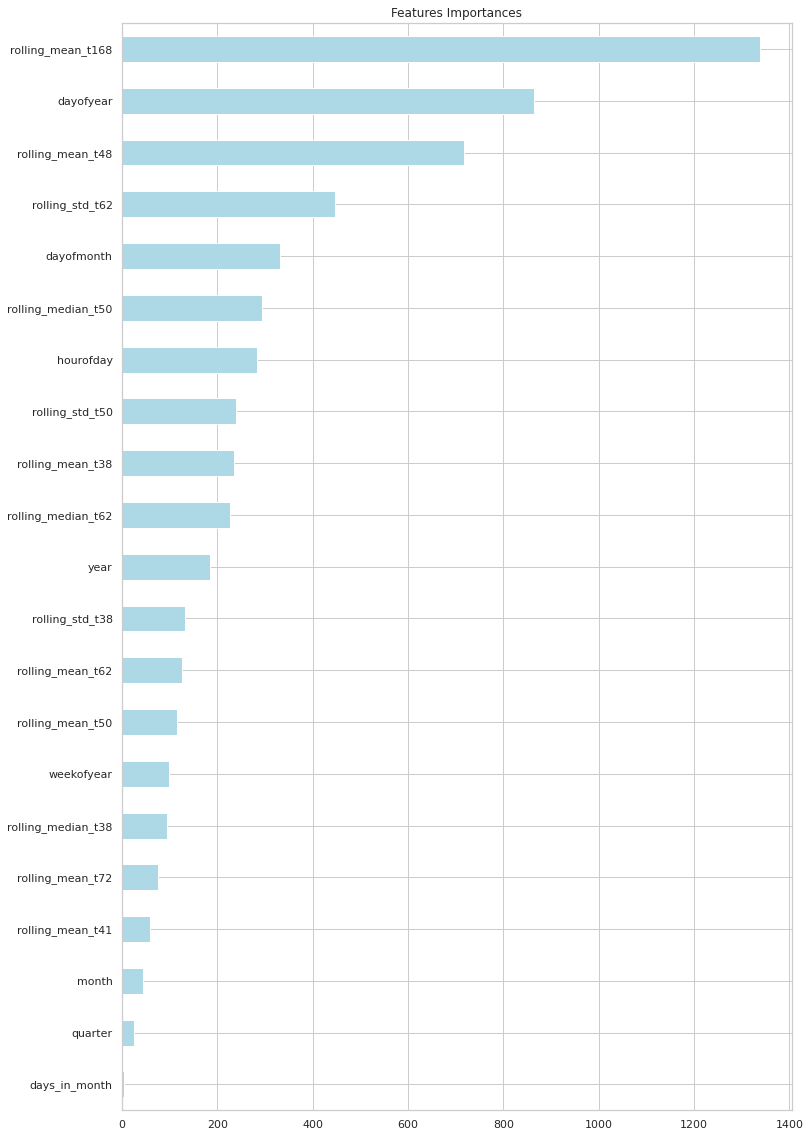

In [39]:
# Create a pd.Series of features importances
importances = pd.Series(data=model_lgbm.feature_importances_,
                        index= df_train.drop('Consumption (MWh)', axis=1).columns)

# Sort importances
importances_sorted = importances.sort_values()
plt.figure(figsize=(12,20))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importances')
plt.show()

This entire code is for educational purposes, for an industry level production ready application, one needs to perform an eloborate feature engineering and an iterative hyperparameter-tuning. For the production phase, time-series spesific cross validation would also help for understanding the generalization power of the model to the future unseen data. In addition, there may be many domain spesific features or some fundamental features those higly affecting the model performance, a few examples to these might be given as: hourly weather condition, Vacation & Special days, features regarding energy consuming factories and sun set & rise data. 

It might be good exercise to try these and further features, selecting the highly correlated ones and also tuning the hyperparameters, finally trying other models such as Random-Forest, XGBoost, NGBoost, Prophet or DNNs (LSTM, etc.).